In [1]:
import torch
from Define_Model.ResNet import LocalResNet
from Define_Model.Loss.SoftmaxLoss import AdditiveMarginLinear

import numpy as np
import kaldi_io
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import pickle

%matplotlib inline
plt.rc('font', family='Times New Roman')


In [2]:
model = LocalResNet(resnet_size=8, block_type='cbam', channels=[64, 128, 256],
                 input_len=300, inst_norm=False, input_dim=161, sr=16000, input_norm='Mean',
                 kernel_size=5, stride=2, padding=2, dropout_p=0.25, exp=False, filter_fix=False,
                 feat_dim=64, num_classes=1211, embedding_size=256, fast='None', time_dim=1, avg_size=4,
                 alpha=0, encoder_type='None', )

model.classifier = AdditiveMarginLinear(feat_dim=256, num_classes=1211)
ckp = torch.load('/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/checkpoint/LoResNet8/vox1/klsp_egs_baseline/arcsoft/None_cbam_em256_alpha0_dp25_wd5e4_dev_var/checkpoint_40.pth')
model.load_state_dict(ckp['state_dict'])

# print(list(ckp['state_dict'][0].keys()))
all_layers = []
for name, m in model.named_modules():
    all_layers.append(name)
    
# print(all_layers)

# module = model.layer4[0].bn2
# b = - (module.running_mean * module.weight / torch.sqrt(module.running_var + module.eps)) + module.bias
# b.data.shape

/home/yangwenhao/anaconda3/envs/py37/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'Define_Model.Loss.SoftmaxLoss.ArcSoftmaxLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/yangwenhao/anaconda3/envs/py37/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [3]:
out_feature_grads = []
in_feature_grads = []

def extract_layer_bias(module):
    # extract bias of each layer

    # for batchnorm, the overall "bias" is different
    # from batchnorm bias parameter.
    # Let m -> running mean, s -> running std
    # Let w -> BN weights, b -> BN bias
    # Then, ((x - m)/s)*w + b = x*w/s + (- m*w/s + b)
    # Thus (-m*w/s + b) is the effective bias of batchnorm
#     print(type(m))
    if isinstance(module, torch.nn.BatchNorm2d):
#         print('bn2')
        b = - (module.running_mean * module.weight
                / torch.sqrt(module.running_var + module.eps)) + module.bias
        return b.data
    elif module.bias is None:
        return None
    else:
        return module.bias.data
    
def _extract_layer_grads(module, in_grad, out_grad):
    # function to collect the gradient outputs
    # from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
    if not module.bias is None:
        in_feature_grads.append(in_grad[0])
        out_feature_grads.append(out_grad[0])
        
in_layer_feat = []
out_layer_feat = []
in_layer_grad = []
out_layer_grad = []

def _extract_layer_feat(module, input, output):
    # function to collect the gradient outputs from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
#     if not module.bias is None:
    in_layer_feat.append(input[0])
    out_layer_feat.append(output[0])
    
    
def _extract_layer_grad(module, in_grad, out_grad):
    # function to collect the gradient outputs from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
    in_layer_grad.append(in_grad[0])
    out_layer_grad.append(out_grad[0])
        

In [4]:
# cam_layers = ['conv1', 'layer1.2.conv2']
cam_layers = ['conv1', 'layer1.0.conv2', 'conv2', 'layer2.0.conv2', 'conv3', 'layer3.0.conv2']

bias_layers = []
biases = []
handlers = []

for name, m in model.named_modules():
    try:
        if name in cam_layers:
            handlers.append(m.register_forward_hook(_extract_layer_feat))
            handlers.append(m.register_backward_hook(_extract_layer_grad))
#         if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.BatchNorm2d):
        if not ('fc' in name or 'classifier' in name or 'CBAM' in name) : 
#             print(m)
            b = extract_layer_bias(m)
            if (b is not None): 
                biases.append(b)
                bias_layers.append(name)
                    
#                 biases.append(_extract_layer_bias(m))
#                 print("bias:", _extract_layer_bias(m))
                m.register_backward_hook(_extract_layer_grads)
#                     m.register_forward_hook(_extract_layer_feat)
    except Exception as e:
        continue

# for name, m in model.named_modules():
#     if not ('fc' in name or 'classifier' in name) : 
#         b = self._extract_layer_bias(m)
#         if (b is not None): 
#             biases.append(b)
#             bias_layers.append(name)
           
print(bias_layers)
print("The number of layers with biases: ", len(biases))

['conv1', 'bn1', 'layer1.0.bn1', 'layer1.0.bn2', 'bn2', 'layer2.0.bn1', 'layer2.0.bn2', 'bn3', 'layer3.0.bn1', 'layer3.0.bn2']
The number of layers with biases:  10


input shape:  torch.Size([1, 1, 811, 161])


([], [])

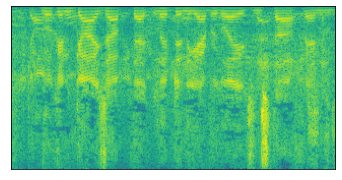

In [5]:
x1 = kaldi_io.read_mat('/home/yangwenhao/local/project/lstm_speaker_verification/data/vox1/klsp/spect/dev/raw_spect_dev.1.ark:26')
x = torch.tensor(x1).reshape(1,1,-1,161).requires_grad_()
print("input shape: ", x.shape)

plt.figure(figsize=(12, 3))
im = plt.imshow(x1.transpose()[:,:320])
plt.xticks([])
plt.yticks([])
# plt.colorbar(im)  # 显示颜色标尺
# print(list(in_feature_grads.keys()))
# print(list(in_feature.keys()))

In [6]:
model.eval()
logits0, feat0 = model(x)
print(logits0[0].max(), torch.max(logits0[0], dim=0)[1])


logits1, feat1 = model(x[:,:,:300])
print(logits1[0].max(), torch.max(logits1[0], dim=0)[1])

logits2, feat2 = model(x[:,:,:400])
print(logits2[0].max(), torch.max(logits2[0], dim=0)[1])

logits3, feat3 = model(x[:,:,:500])
print(logits3[0].max(), torch.max(logits3[0], dim=0)[1])

logits4, feat4 = model(x[:,:,:600])
print(logits4[0].max(), torch.max(logits4[0], dim=0)[1])

logits5, feat5 = model(x[:,:,300:600])
print(logits5[0].max(), torch.max(logits5[0], dim=0)[1])

logits6, feat6 = model(x[:,:,600:])
print(logits6[0].max(), torch.max(logits6[0], dim=0)[1])

featx = (feat1 +feat5+feat6)/3
logitsx = model.classifier(featx)
print(logitsx[0].max(), torch.max(logitsx[0], dim=0)[1])



tensor(0.7906, grad_fn=<MaxBackward1>) tensor(0)
tensor(0.7065, grad_fn=<MaxBackward1>) tensor(0)
tensor(0.7414, grad_fn=<MaxBackward1>) tensor(0)
tensor(0.7718, grad_fn=<MaxBackward1>) tensor(0)
tensor(0.7725, grad_fn=<MaxBackward1>) tensor(0)
tensor(0.7294, grad_fn=<MaxBackward1>) tensor(0)
tensor(0.6950, grad_fn=<MaxBackward1>) tensor(0)
tensor(0.7949, grad_fn=<MaxBackward1>) tensor(0)


In [7]:
model.eval()
logits, feat = model(x)
print(torch.max(logits, dim=1))
logits[0].max().backward()
# print(feature_grads[0].shape)

torch.return_types.max(
values=tensor([0.7906], grad_fn=<MaxBackward0>),
indices=tensor([0]))


In [8]:
x_stdf = x.std(dim=2)
# print(input_x.shape)
# print(input_x)

In [9]:
print("Num of stored biases layers: ", len(bias_layers))
print("Num of stored gradient of biases layers: ", len(out_feature_grads))

ups = torch.nn.UpsamplingBilinear2d(size=(811, 161))
grad = x.grad# .clamp_min(0)
ingrad = grad.clone().abs()
# ingrad = grad.clamp_min(0)
# ingrad /= ingrad.sum()
# ingrad = grad_pp.abs()

# stap grad
stap_grad = grad.clone()
# stap_grad -= stap_grad.min()
# stap_grad /= stap_grad.max()
stap_grad *= 1 + np.sqrt((1-stap_grad).pow(2))
stap_grad /= stap_grad.max()

# grad ++
first_derivative = logits[0].max().exp() * grad
feat = x.clone()
alpha = grad.pow(2) / (2 * grad.pow(2) + (grad.pow(3) * feat).sum(dim=(2, 3), keepdim=True))
grad_pp = alpha * first_derivative# (first_derivative.clamp_min(0))
grad_pp = grad_pp.abs()

# grad cam
grad_cam = torch.zeros_like(x)
L = len(cam_layers)
assert len(out_layer_grad) == L, print(len(out_layer_grad))

last_grad = out_layer_grad[0]
last_feat = out_layer_feat[-1]

T = (last_feat.clone() * last_grad.clone()).clamp_min(0).sum(dim=1, keepdim=True)
grad_cam += ups(T)# .abs()
grad_cam = grad_cam.clamp_min(0)
grad_cam /= grad_cam.sum()


# grad cam ++ last
last_grad = out_layer_grad[0].clone()# .clamp_min(0)
last_feat = out_layer_feat[-1].clone()
first_derivative = logits[0].max().exp() * last_grad
alpha = last_grad.pow(2) / (2 * last_grad.pow(2) + (last_grad.pow(3) * last_feat).sum(dim=(2, 3), keepdim=True))
weight = alpha * (first_derivative.abs())

weight = weight.mean(dim=(2, 3), keepdim=True)
weight /= weight.sum()

grad_cam_pp = (last_feat * weight).sum(dim=1, keepdim=True)
grad_cam_pp = ups(grad_cam_pp)

# grad_cam_pp -= grad_cam_pp.min()
grad_cam_pp = grad_cam_pp.abs()
# grad_cam_pp = grad_cam_pp.clamp_min(0)
grad_cam_pp /= grad_cam_pp.sum()

# full grad
input_gradient = (x.grad * x)#.clamp_min(0)

full_grad = input_gradient.clone()
full_grad -= full_grad.min()
full_grad /= full_grad.max()

L = len(bias_layers)
for i,l in enumerate(bias_layers):
    bias = biases[L-i-1]
    if len(bias.shape) == 1:
        bias = bias.reshape(1,-1,1,1)
    bias = bias.expand_as(out_feature_grads[i])
    
#     bias_grad = (out_feature_grads[i]*bias).sum(dim=1, keepdim=True)
#     bias_grad = (out_feature_grads[i]*bias).mean(dim=1, keepdim=True)
    bias_grad = (out_feature_grads[i]*bias).sum(dim=1, keepdim=True).clamp_min(0)
    bias_grad -= bias_grad.min()
    bias_grad /= bias_grad.max()
    full_grad += ups(bias_grad)
    
# full_grad -= full_grad.min()
# full_grad = full_grad.abs()
full_grad = full_grad.clamp_min(0)
full_grad /= full_grad.sum()

# vis_grad = [x, ingrad/ingrad.max(), grad_pp, stap_grad, ingrad*x_stdf, grad_cam, grad_cam_pp, full_grad]
# names = ['input', 'grad', 'grad_pp', 'stap_grad', 'grad*std', 'grad_cam', 'grad_cam++', 'full_grad']

names = ['Spectrogram', 'grad', 'grad_cam', 'grad_cam++', 'full_grad']
vis_grad = [x, ingrad, grad_cam, grad_cam_pp, full_grad]


Num of stored biases layers:  10
Num of stored gradient of biases layers:  10


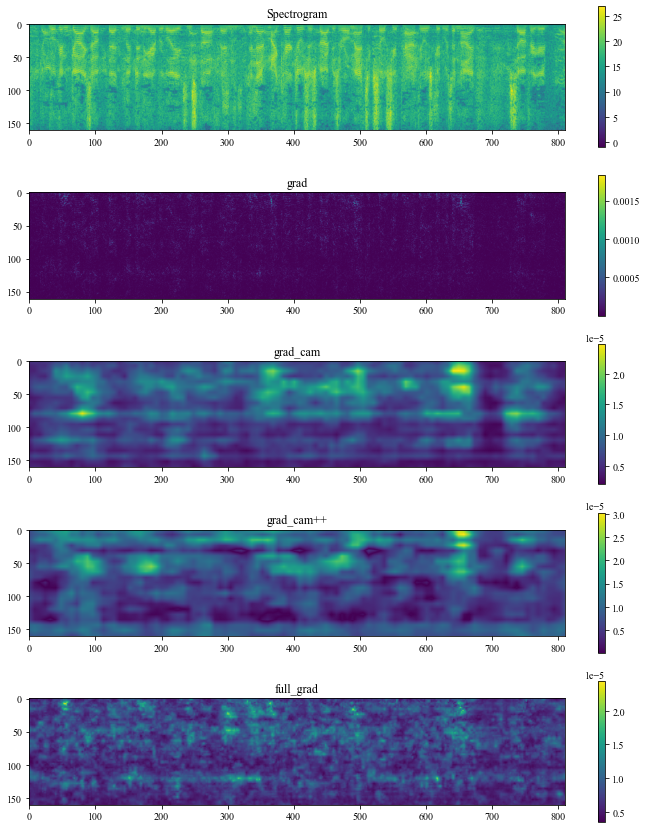

In [10]:
plt.figure(figsize=(12, 15))
# norm = matplotlib.colors.Normalize(vmin=-10., vmax=10.)
for i in range(len(vis_grad)):
    ax = plt.subplot(len(vis_grad), 1, i+1)
    ax.set_title(names[i])
    im = ax.imshow(vis_grad[i].squeeze().detach().numpy().transpose()) #, norm=norm)
    plt.colorbar(im)  # 显示颜色标尺


/home/yangwenhao/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6


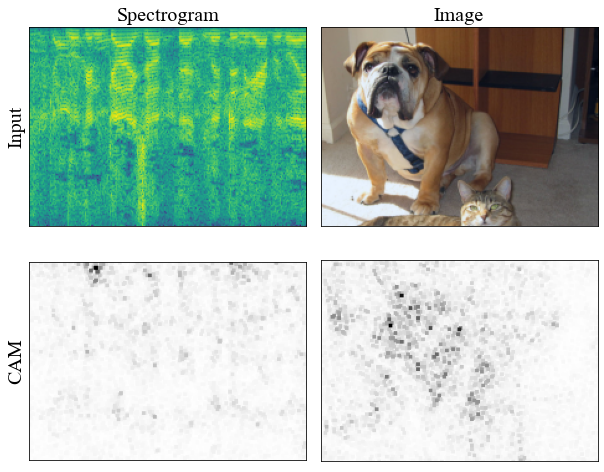

In [14]:
pdf = PdfPages('input_cam.pdf')

# plt.figure(figsize=(15, 8))
plt.figure(figsize=(8.5, 7))

# norm = matplotlib.colors.Normalize(vmin=-10., vmax=10.)
# for i in range(2):

i=0
ax = plt.subplot(2, 2, 1)
ax.set_title(names[i], fontsize=20)
this_im = vis_grad[i].squeeze().detach().numpy().transpose()[:, :224]
this_im = this_im/this_im.max()

im = ax.imshow(this_im) #, norm=norm)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel("Input", fontsize=20)
# plt.colorbar(im)  # 显示颜色标尺

i=1
ax = plt.subplot(2, 2, 3)
# ax.set_title("CAM")
this_im_grad = vis_grad[i].squeeze().detach().numpy().transpose()[:, :224]

# this_im = np.power(this_im)

this_im_grad = torch.nn.functional.max_pool2d(torch.tensor(this_im_grad).unsqueeze(0), kernel_size=3, stride=1)
this_im_grad -= this_im_grad.min()
this_im_grad = this_im_grad/this_im_grad.max()

im = ax.imshow(this_im_grad.squeeze(), cmap='Greys') #, norm=norm)

# im = ax.imshow(this_im_grad.squeeze(), cmap='afmhot') #, norm=norm)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel("CAM", fontsize=20)

# plt.colorbar(im)  # 显示颜色标尺

filename = 'grad_cam/im_grad.pickle'
with open(filename, 'rb') as f:
    im_dict = pickle.load(f)

ax = plt.subplot(2, 2, 2)
ax.set_title("Image", fontsize=20)
input_im = im_dict["input_im"]
# input_im = torch.nn.functional.max_pool2d(torch.tensor(input_im).unsqueeze(0), kernel_size=3)

im = ax.imshow(input_im[:161,:]) #, norm=norm)
ax.set_yticks([])
ax.set_xticks([])

# plt.colorbar(im)  # 显示颜色标尺

ax = plt.subplot(2, 2, 4)
# ax.set_title("CAM")
input_im_grad = im_dict["input_im_grad"]
input_im_grad = torch.nn.functional.max_pool2d(torch.tensor(input_im_grad).unsqueeze(0), kernel_size=3, stride=1)
input_im_grad -= input_im_grad.min()
input_im_grad /= input_im_grad.max()

im = ax.imshow(input_im_grad.squeeze()[:161,:], cmap='Greys') #, norm=norm) YlOrBr
# im = ax.imshow(input_im_grad.squeeze()[:161,:], cmap='afmhot') #, norm=norm) YlOrBr


ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()
# plt.colorbar(im)  # 显示颜色标尺
pdf.savefig(layout='tight')

pdf.savefig()
pdf.close()

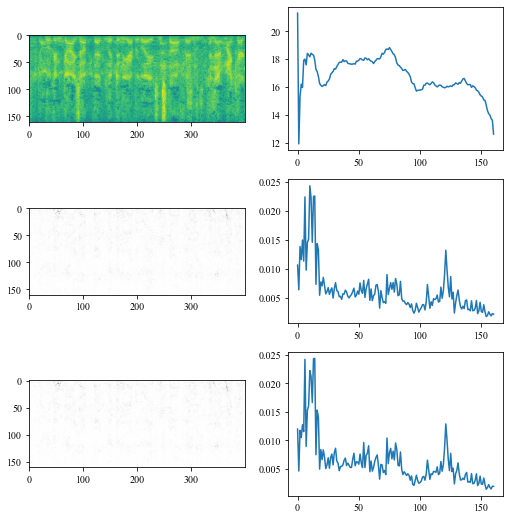

In [34]:
this_im = vis_grad[0].squeeze().detach().numpy().transpose()[:, :400]
plt.figure(figsize=(8.5, 9))

ax = plt.subplot(3, 2, 1)
im = plt.imshow(this_im) #, norm=norm)

ax = plt.subplot(3, 2, 2)
plt.plot(this_im.mean(axis=1))

this_grad = vis_grad[1].squeeze().detach().numpy().transpose()[:, :400]

ax = plt.subplot(3, 2, 3)
im = plt.imshow(this_grad, cmap='Greys')#, norm=norm)

ax = plt.subplot(3, 2, 4)
weight = this_grad.max(axis=1)
plt.plot(weight/weight.sum())


ax = plt.subplot(3, 2, 5)
im = plt.imshow(this_im*this_grad, cmap='Greys') #, norm=norm)

ax = plt.subplot(3, 2, 6)
weight = (this_grad*this_im).max(axis=1)
plt.plot(weight/weight.sum())


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

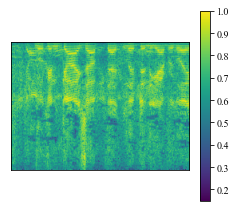

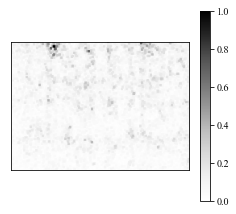

In [104]:
# pdf = PdfPages('input_cam.pdf')

# plt.figure(figsize=(15, 8))
# plt.figure(figsize=(8.5, 7))

i=0
# ax = plt.subplot(2, 2, 1)
pdf = PdfPages('grad_cam/a.pdf')
plt.figure(figsize=(4, 3.5))

# ax.set_title(names[i])
this_im = vis_grad[i].squeeze().detach().numpy().transpose()[:, :224]
this_im = this_im/this_im.max()

im = plt.imshow(this_im) #, norm=norm)
plt.yticks([])
plt.xticks([])
plt.colorbar(im)  # 显示颜色标尺
pdf.savefig()
pdf.close()

i=1
# ax = plt.subplot(2, 2, 3)
pdf = PdfPages('grad_cam/b.pdf')
plt.figure(figsize=(4, 3.5))
# plt.set_title("CAM")
this_im_grad = vis_grad[i].squeeze().detach().numpy().transpose()[:, :224]

# this_im = np.power(this_im)
this_im_grad = torch.nn.functional.max_pool2d(torch.tensor(this_im_grad).unsqueeze(0), kernel_size=3, stride=1)
this_im_grad -= this_im_grad.min()
this_im_grad = this_im_grad/this_im_grad.max()
# print(this_im_grad.shape, this_im_grad[0])
im = plt.imshow(this_im_grad.squeeze(), cmap='Greys') #, norm=norm)
plt.yticks([])
plt.xticks([])

plt.colorbar(im)  # 显示颜色标尺
pdf.savefig()
pdf.close()

filename = 'grad_cam/im_grad.pickle'
with open(filename, 'rb') as f:
    im_dict = pickle.load(f)

# ax = plt.subplot(2, 2, 2)
# plt.set_title("Image")
input_im = im_dict["input_im"]
# input_im = torch.nn.functional.max_pool2d(torch.tensor(input_im).unsqueeze(0), kernel_size=3)
pdf = PdfPages('grad_cam/c.pdf')
plt.figure(figsize=(4, 3.5))

im = plt.imshow(input_im[:161,:]) #, norm=norm)
plt.yticks([])
plt.xticks([])

plt.colorbar(im)  # 显示颜色标尺
pdf.savefig()
pdf.close()

# ax = plt.subplot(2, 2, 4)
# ax.set_title("CAM")
input_im_grad = im_dict["input_im_grad"]
input_im_grad = torch.nn.functional.max_pool2d(torch.tensor(input_im_grad).unsqueeze(0), kernel_size=3, stride=1)
input_im_grad -= input_im_grad.min()
input_im_grad /= input_im_grad.max()
pdf = PdfPages('grad_cam/d.pdf')

plt.figure(figsize=(4, 3.5))

im = plt.imshow(input_im_grad.squeeze()[:161,:], cmap='Greys') #, norm=norm) YlOrBr
plt.yticks([])
plt.xticks([])
plt.colorbar(im)  # 显示颜色标尺
pdf.savefig()
pdf.close()

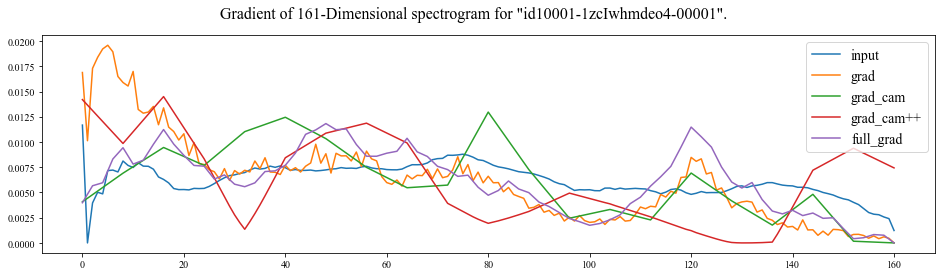

In [26]:
plt.figure(figsize=(16, 4))
names_np = np.array(names)
indexs = np.array([0, 1, 2, 3, 4])
plt.suptitle("Gradient of 161-Dimensional spectrogram for \"id10001-1zcIwhmdeo4-00001\".", fontsize=16)

# for i in [1,2, 3]:
for i in indexs:

    grad_plus = vis_grad[i].squeeze().detach().numpy()# .transpose()
    freq_grad = grad_plus.mean(axis=0)      # Mean along with the time axis
    freq_grad -= freq_grad
    freq_grad /= freq_grad.sum()            # Normalization

    plt.plot(freq_grad)

plt.legend(names_np[indexs], fontsize=14)


In [13]:
input_norm = vis_grad[0].squeeze().detach().numpy().mean(axis=0)[1:-2]
input_norm /= input_norm.sum()
def plot_grad(grad, axis):
    this_grad = grad.squeeze().detach().numpy().transpose().mean(axis=axis)
    this_grad /= this_grad.sum()
    plt.plot(this_grad)
   
# plot part of gradients, where the the sum is greater than the threshold, mean-2std.
def plot_part_grad(grad, axis):
    this_grad = grad.squeeze().detach().numpy()# .transpose()
    all_time = len(this_grad)
    grad_plus_time = this_grad.mean(axis=1)
    grad_plus_time_mean = grad_plus_time.mean() - 2*grad_plus_time.std()
#     grad_plus_time_mean = 
    
    freq_grad = this_grad[np.where(grad_plus_time>grad_plus_time_mean)[0]]
    part_time = len(freq_grad)
    this_grad = freq_grad.mean(axis=0)[1:-2]
    
    print(part_time/all_time)
    this_grad /= input_norm
    this_grad /= this_grad.sum()
    
    plt.plot(this_grad[1:-2])


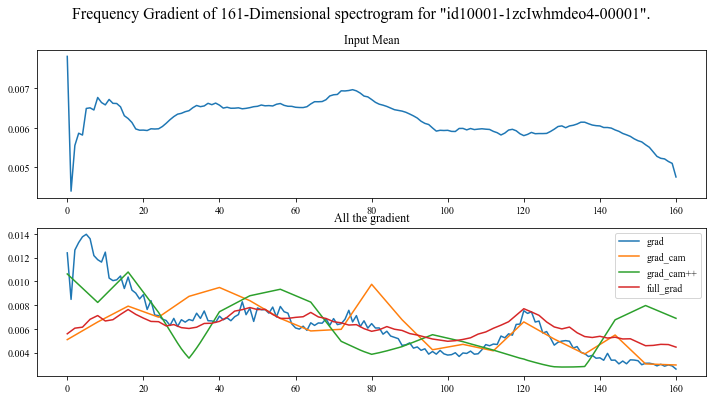

In [19]:
plt.figure(figsize=(12, 6))
plt.suptitle("Frequency Gradient of 161-Dimensional spectrogram for \"id10001-1zcIwhmdeo4-00001\".", fontsize=16)

plt.subplot(2,1,1)
plt.title("Input Mean")
plot_grad(vis_grad[0], 1)
    
plt.subplot(2,1,2)
plt.title("All the gradient")
for i in range(1, len(vis_grad)):
    plot_grad(vis_grad[i], 1)
    
plt.legend(['grad', 'grad_cam', 'grad_cam++', 'full_grad'])

# plt.subplot(3,1,3)
# plt.title("The gradient is greater that mean-2std")

# for i in range(1, len(vis_grad)):
#     plot_part_grad(vis_grad[i], 1)

# plt.legend(['grad', 'grad*std', 'grad_cam', 'grad_cam++', 'full_grad'])


0.0 0.009396155
0.0 0.008547108


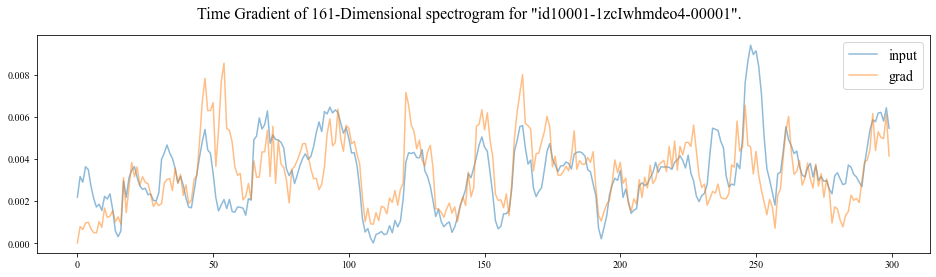

In [112]:
plt.figure(figsize=(16, 4))

def plot_energy(grad, axis, lenght=300):
    this_grad = grad.squeeze().detach().numpy().transpose().mean(axis=axis)
    this_grad = this_grad[:lenght]
#     print(this_grad.min())
    this_grad -= this_grad.min()
    this_grad /= this_grad.sum()
    print(this_grad.min(), this_grad.max())
    
    plt.plot(this_grad, alpha=0.5)
    
plt.suptitle("Time Gradient of 161-Dimensional spectrogram for \"id10001-1zcIwhmdeo4-00001\".", fontsize=16)

# for i in range(len(vis_grad)):
indexs = [0,1]
for i in indexs:
    plot_energy(vis_grad[i], 0, lenght=300)

plt.legend(names_np[indexs], fontsize=14)

In [65]:
axis=0
lenght=300

this_grad = vis_grad[0].squeeze().detach().numpy().transpose().mean(axis=axis)
this_grad = this_grad[:lenght]
#     print(this_grad.min())
this_grad -= this_grad.min()
this_grad /= this_grad.max()
print(this_grad.min(), this_grad.max())

0.0 1.0


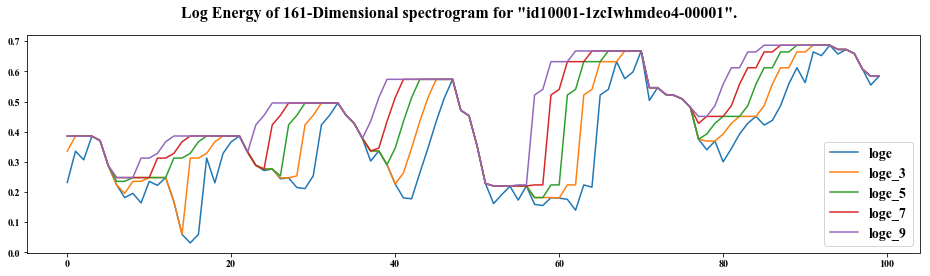

In [104]:
log_energy = torch.FloatTensor(this_grad)
max_pooling = torch.nn.MaxPool1d(kernel_size=3, stride=1, padding=0)
log_energy_max3 = max_pooling(log_energy.reshape(1,1,-1))
log_energy_max33 = max_pooling(log_energy_max3)


max_pooling = torch.nn.MaxPool1d(kernel_size=5, stride=1, padding=0)
log_energy_max5 = max_pooling(log_energy.reshape(1,1,-1))
log_energy_max55 = max_pooling(log_energy_max5)

max_pooling = torch.nn.MaxPool1d(kernel_size=7, stride=1, dilation=1, padding=0)
log_energy_max7 = max_pooling(log_energy.reshape(1,1,-1))

log_energy_max77 = max_pooling(log_energy_max7)

max_pooling = torch.nn.MaxPool1d(kernel_size=9, stride=1, padding=0)
log_energy_max9 = max_pooling(log_energy.reshape(1,1,-1))

# energies = [log_energy,log_energy_max3, log_energy_max33, log_energy_max5, log_energy_max55, log_energy_max7, log_energy_max77]

energies = [log_energy, log_energy_max3, log_energy_max5, log_energy_max7, log_energy_max9]

plt.figure(figsize=(16, 4))    
plt.suptitle("Log Energy of 161-Dimensional spectrogram for \"id10001-1zcIwhmdeo4-00001\".", fontsize=16)
# for i in range(len(vis_grad)):
for i in energies:
#     plt.plot(i.squeeze(), alpha=0.3)
    plt.plot(i.squeeze()[:100])

plt.legend(['loge', 'loge_3', 'loge_5', 'loge_7', 'loge_9',], fontsize=14)

Mean:  tensor(0.3548)  Std:  tensor(0.1768)
Mean:  tensor(0.4673)  Std:  tensor(0.1707)


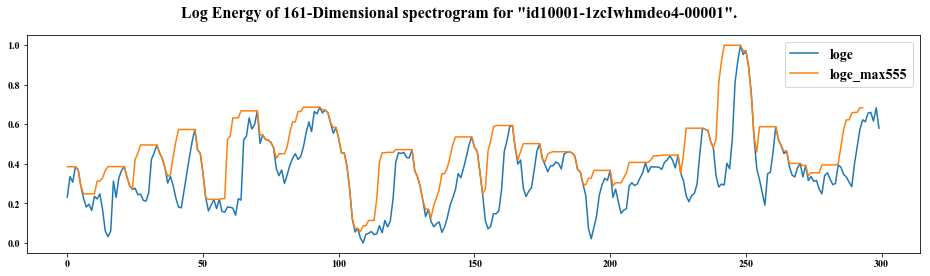

In [116]:
log_energy = torch.FloatTensor(this_grad)
max_pooling = torch.nn.MaxPool1d(kernel_size=3, stride=1, padding=0)
log_energy_max3 = max_pooling(log_energy.reshape(1,1,-1))
log_energy_max33 = max_pooling(log_energy_max3)
log_energy_max333 = max_pooling(log_energy_max33)


avg_pooling = torch.nn.AvgPool1d(kernel_size=9, stride=1, padding=0)
log_energy_avg7 = avg_pooling(log_energy.reshape(1,1,-1))


max_pooling = torch.nn.MaxPool1d(kernel_size=9, stride=1, dilation=1, padding=0)
log_energy_max7 = max_pooling(log_energy.reshape(1,1,-1))

# energies = [log_energy,log_energy_max3, log_energy_max33, log_energy_max5, log_energy_max55, log_energy_max7, log_energy_max77]

# energies = [log_energy, log_energy_avg7, log_energy_max7, (log_energy_avg7+log_energy_max7)/2]
energies = [log_energy, log_energy_max333]#, log_energy_avg7, log_energy_max7, (log_energy_avg7+log_energy_max7)/2]

plt.figure(figsize=(16, 4))    
plt.suptitle("Log Energy of 161-Dimensional spectrogram for \"id10001-1zcIwhmdeo4-00001\".", fontsize=16)
# for i in range(len(vis_grad)):
for i in energies:
#     plt.plot(i.squeeze(), alpha=0.3)
    plt.plot(i.squeeze()[:300])
    print('Mean: ', i.mean(), ' Std: ', i.std())

plt.legend(['loge', 'loge_max555', 'loge_avg7', 'loge_max7', 'loge_avg+max7',], fontsize=14)
